# Cal-CRAI Index: Weighting Climate Risk Scenarios

**Order of operations**:
- Metric handling
   - Retrieve & clean data
   - Merge data domains together
   - Calculate domain medians and adjusted scores
   - Mask SLR layers to non-coastal tracts
- Custom weight per scenairo
   - merge index scores per scenario together
- Bin values into _ sections

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_unweighted_index, calculate_weighted_index, weight_domains, print_index_summary, min_max_standardize
from scripts.utils.index_plots import index_plot, index_domain_plot

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


## Pull domain-specific index calculations from AWS

In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

## Clean data, isolate relevant columns

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]

# For climate domain, keep first seven columns
climate_domain_cleaned = climate_domain.iloc[:, :7]

## Merge the core domain dataframes together

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

## Clean the merged core domain dataframe

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.651308,0.605062,0.518637,0.833488
1,06001400200,0.651308,0.553534,0.366578,0.841855
2,06001400300,0.651308,0.557473,0.338360,0.793298
3,06001400400,0.651308,0.549355,0.358216,0.770451
4,06001400500,0.651308,0.552923,0.367882,0.744977
...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342
9125,06115041001,0.682143,0.416459,0.466137,0.742681
9126,06115041002,0.682143,0.432561,0.584687,0.766956
9127,06115041101,0.682143,0.391202,0.683639,0.736324


## Calculate built, natural systems, and society & economy domain median values

In [7]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805
...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805


## Calculate built, natural systems, and society & economy domain adjusted values

In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102


## Bring in Climate Data

In [9]:
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,6001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510
1,6001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643
2,6001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542
3,6001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913
4,6001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532
...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.846492,0.000000,0.619160
9125,6115041001,0.382023,0.311958,0.374011,0.873744,0.000000,0.527876
9126,6115041002,0.396227,0.322660,0.377173,0.819991,0.000000,0.585439
9127,6115041101,0.361174,0.353338,0.322773,0.651207,0.000000,0.539505


## Pull SLR mask data

In [10]:
slr_mask_data = '../utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})

In [11]:
slr_mask

,GEOID,slr_impacted
0,6085504321,1
1,6085504410,1
2,6085507003,1
3,6085507004,1
4,6085502204,1
...,...,...
9124,6059001303,1
9125,6059001304,1
9126,6059001401,1
9127,6013367200,1


## Merge slr mask data with climate data

In [12]:
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)
slr_mask['GEOID'] = slr_mask['GEOID'].astype(str)

processed_climate_df = pd.merge(climate_domain_cleaned, slr_mask, on='GEOID', how='left')
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,slr_impacted
0,6001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510,1
1,6001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643,1
2,6001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542,1
3,6001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913,1
4,6001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532,1
...,...,...,...,...,...,...,...,...
9124,6115040902,0.409434,0.324800,0.382787,0.846492,0.000000,0.619160,0
9125,6115041001,0.382023,0.311958,0.374011,0.873744,0.000000,0.527876,0
9126,6115041002,0.396227,0.322660,0.377173,0.819991,0.000000,0.585439,0
9127,6115041101,0.361174,0.353338,0.322773,0.651207,0.000000,0.539505,0


## If SLR impacted column is 0, set sea level rise column to NaN as they are inland tracts

In [13]:
processed_climate_df.loc[processed_climate_df['slr_impacted'] == 0, 'sea_level_rise_exposure_loss_product_min_max_standardized'] = np.nan

In [14]:
# turned off for now, but some tracts have a prefix that may be water tracts that could be masked?
'''# Identify GEOID values that start with '6099' in climate_domain_cleaned
submerged_coastal_rows = climate_domain_cleaned[climate_domain_cleaned['GEOID'].astype(str).str.startswith('6099')]['GEOID']

# Set the specific column to NaN for matching GEOIDs in processed_climate_df
processed_climate_df.loc[
    processed_climate_df['GEOID'].isin(submerged_coastal_rows), 
    'sea_level_rise_exposure_loss_product_min_max_standardized'
] = float('nan')'''

"# Identify GEOID values that start with '6099' in climate_domain_cleaned\nsubmerged_coastal_rows = climate_domain_cleaned[climate_domain_cleaned['GEOID'].astype(str).str.startswith('6099')]['GEOID']\n\n# Set the specific column to NaN for matching GEOIDs in processed_climate_df\nprocessed_climate_df.loc[\n    processed_climate_df['GEOID'].isin(submerged_coastal_rows), \n    'sea_level_rise_exposure_loss_product_min_max_standardized'\n] = float('nan')"

## Clean climate dataframe

In [15]:
# Ensure all values in GEOID are strings
processed_climate_df['GEOID'] = processed_climate_df['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
processed_climate_df['GEOID'] = processed_climate_df['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

processed_climate_df = processed_climate_df.drop(columns='slr_impacted')

# Display the dataframe
processed_climate_df

,GEOID,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510
1,06001400200,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643
2,06001400300,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542
3,06001400400,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913
4,06001400500,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532
...,...,...,...,...,...,...,...
9124,06115040902,0.409434,0.324800,0.382787,0.846492,NaN,0.619160
9125,06115041001,0.382023,0.311958,0.374011,0.873744,NaN,0.527876
9126,06115041002,0.396227,0.322660,0.377173,0.819991,NaN,0.585439
9127,06115041101,0.361174,0.353338,0.322773,0.651207,NaN,0.539505


## Merge core and climate dataframes together

In [16]:
core_and_climate_domains = pd.merge(all_domains, processed_climate_df, on='GEOID', how='left')

In [17]:
core_and_climate_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099,0.409434,0.324800,0.382787,0.846492,NaN,0.619160
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789,0.382023,0.311958,0.374011,0.873744,NaN,0.527876
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726,0.396227,0.322660,0.377173,0.819991,NaN,0.585439
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102,0.361174,0.353338,0.322773,0.651207,NaN,0.539505


## Custom Weighting to calculate Cal-CRAI score for specific climate risks
* utilize weight domains function to adjust domain coefficients to desired weighting factor

## Wildfire

In [18]:
# different weighting
df_fire = weight_domains(core_and_climate_domains, society=0.89, built=0.87, natural=0.72)
df_fire = calculate_weighted_index(df_fire, 'wildfire_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_fire = df_fire.rename(columns={'calcrai_score':'wildfire_scenario_calcrai_score'})

df_fire.to_csv('calcrai_index_wildfire_scenario_updated.csv', index=False)
print_index_summary(df_fire, 'wildfire_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  12.037693823976426
Mean score / average resilience:  1.9631967149533334
Median score / median resilience:  1.1092864806653207


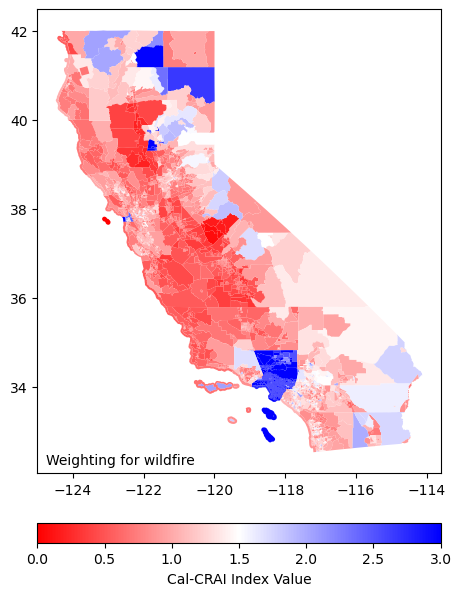

In [19]:
index_plot(df_fire, 'wildfire_scenario_calcrai_score', scenario='wildfire', vmin=0, vmax=3)

## Extreme Heat

In [20]:
df_heat = weight_domains(core_and_climate_domains, society=0.87, built=0.81, natural=0.75)
df_heat = calculate_weighted_index(df_heat, 'extreme_heat_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_heat = df_heat.rename(columns={'calcrai_score':'extreme_heat_scenario_calcrai_score'})

df_heat.to_csv('calcrai_index_heat_scenario_updated.csv', index=False)
print_index_summary(df_heat, 'extreme_heat_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  70.71240841997916
Mean score / average resilience:  1.658876303627315
Median score / median resilience:  1.051045420744143


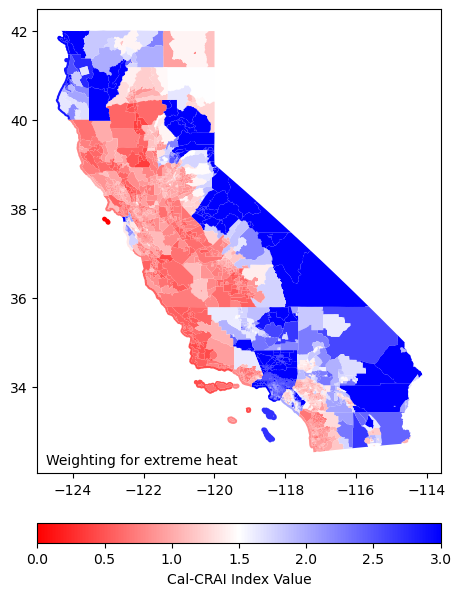

In [21]:
index_plot(df_heat, 'extreme_heat_scenario_calcrai_score', scenario='extreme heat', vmin=0, vmax=3)

## Inland Flooding

In [22]:
df_inland_flooding = weight_domains(core_and_climate_domains, society=0.92, built=0.83, natural=0.58)
df_inland_flooding = calculate_weighted_index(df_inland_flooding, 'inland_flooding_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_inland_flooding = df_inland_flooding.rename(columns={'calcrai_score':'inland_flooding_scenario_calcrai_score'})

df_inland_flooding.to_csv('calcrai_index_inland_flooding_scenario_updated.csv', index=False)
print_index_summary(df_inland_flooding, 'inland_flooding_scenario_calcrai_score')

Min score / less resilience:  0.0
Max score / more resilience:  8.90377115470528
Mean score / average resilience:  1.7218602327781583
Median score / median resilience:  1.3009724929309365


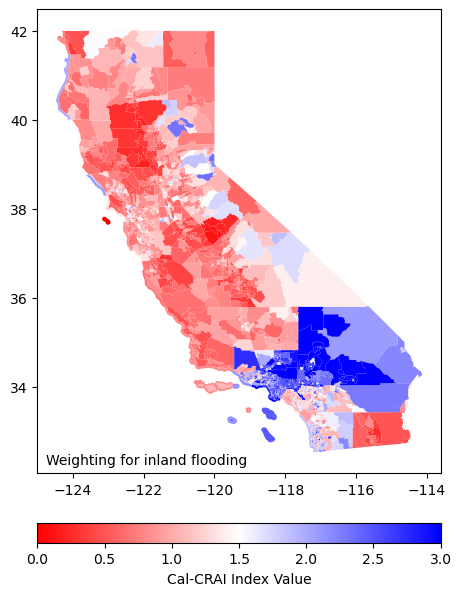

In [23]:
index_plot(df_inland_flooding, 'inland_flooding_scenario_calcrai_score', scenario='inland flooding', vmin=0, vmax=3)

## Sea Level Rise

In [24]:
df_sea_level_rise = weight_domains(core_and_climate_domains, society=0.92, built=0.75, natural=0.82)
df_sea_level_rise = calculate_weighted_index(df_sea_level_rise, 'sea_level_rise_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_sea_level_rise = df_sea_level_rise.rename(columns={'calcrai_score':'sea_level_rise_scenario_calcrai_score'})

df_sea_level_rise.to_csv('calcrai_index_sea_level_rise_scenario_updated.csv', index=False)
print_index_summary(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score')


Min score / less resilience:  0.0
Max score / more resilience:  20.014546305744265
Mean score / average resilience:  1.8806714930533823
Median score / median resilience:  1.3741173546997885


In [25]:
df_sea_level_rise

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,all_domain_loss_exposure_product_min_max_standardized,drought_exposure_loss_product_min_max_standardized,extreme_heat_exposure_loss_product_min_max_standardized,wildfire_exposure_loss_product_min_max_standardized,sea_level_rise_exposure_loss_product_min_max_standardized,inland_flooding_exposure_loss_product_min_max_standardized,calcrai_weighted,sea_level_rise_scenario_calcrai_score
0,06001400100,0.651308,0.605062,0.518637,0.833488,0.642475,0.451652,0.748805,0.148310,0.113091,-0.058232,0.753671,0.878232,0.769035,0.546436,0.304982,0.617510,0.769835,2.524201
1,06001400200,0.651308,0.553534,0.366578,0.841855,0.642475,0.451652,0.748805,-0.188363,0.124264,-0.138434,0.704640,0.878232,0.792429,0.605283,0.323460,0.409643,0.557546,1.723693
2,06001400300,0.651308,0.557473,0.338360,0.793298,0.642475,0.451652,0.748805,-0.250839,0.059419,-0.132304,0.764024,0.852784,0.828517,0.605283,0.283089,0.614542,0.488318,1.724964
3,06001400400,0.651308,0.549355,0.358216,0.770451,0.642475,0.451652,0.748805,-0.206877,0.028908,-0.144939,0.702309,0.852784,0.828517,0.605283,0.305819,0.406913,0.487342,1.593562
4,06001400500,0.651308,0.552923,0.367882,0.744977,0.642475,0.451652,0.748805,-0.185476,-0.005111,-0.139386,0.781995,0.852784,0.828517,0.605283,0.316931,0.614532,0.481100,1.517997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.783342,0.642475,0.451652,0.748805,0.044468,0.046124,-0.270099,0.409434,0.324800,0.382787,0.846492,NaN,0.619160,0.597778,NaN
9125,06115041001,0.682143,0.416459,0.466137,0.742681,0.642475,0.451652,0.748805,0.032071,-0.008179,-0.351789,0.382023,0.311958,0.374011,0.873744,NaN,0.527876,0.514971,NaN
9126,06115041002,0.682143,0.432561,0.584687,0.766956,0.642475,0.451652,0.748805,0.294550,0.024240,-0.326726,0.396227,0.322660,0.377173,0.819991,NaN,0.585439,0.694959,NaN
9127,06115041101,0.682143,0.391202,0.683639,0.736324,0.642475,0.451652,0.748805,0.513641,-0.016668,-0.391102,0.361174,0.353338,0.322773,0.651207,NaN,0.539505,0.758901,NaN


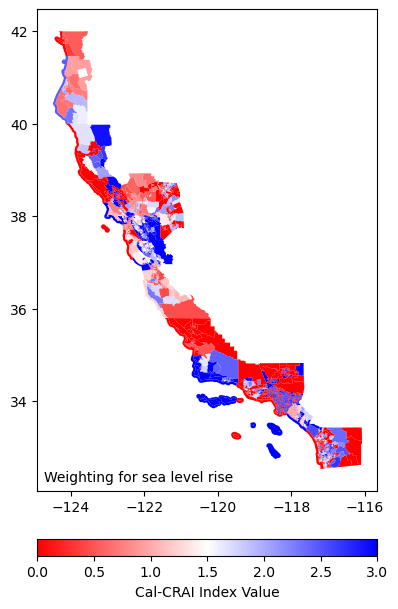

In [26]:
index_plot(df_sea_level_rise, 'sea_level_rise_scenario_calcrai_score', scenario='sea level rise',  vmin=0, vmax=3)

## Drought

In [27]:
df_drought = weight_domains(core_and_climate_domains, society=1.15, built=1.05, natural=1.42)
df_drought = calculate_weighted_index(df_drought, 'drought_exposure_loss_product_min_max_standardized')

# rename the index column to represent the weighting scenario
df_drought = df_drought.rename(columns={'calcrai_score':'drought_scenario_calcrai_score'})

df_drought.to_csv('calcrai_index_drought_scenario_updated.csv', index=False)
print_index_summary(df_drought, 'drought_scenario_calcrai_score')

Min score / less resilience:  -0.9380114938253005
Max score / more resilience:  50.18092912075416
Mean score / average resilience:  2.7962656202654257
Median score / median resilience:  1.9786538822055073


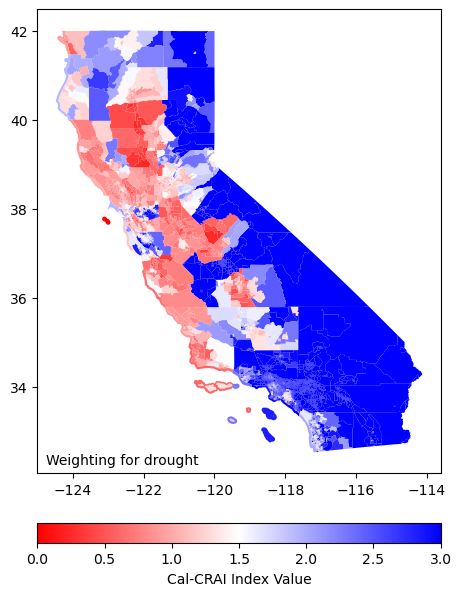

In [28]:
index_plot(df_drought, 'drought_scenario_calcrai_score', scenario='drought',  vmin=0, vmax=3)

## Merge all weighted index scores together

In [29]:
# List of dataframes to merge
dfs = [df_drought, df_fire, df_heat, df_sea_level_rise, df_inland_flooding]

# Keep only 'geoid' and columns ending with '_calcrai_score' in each dataframe
dfs = [df[['GEOID'] + [col for col in df.columns if col.endswith('_calcrai_score')]] for df in dfs]

# Merge all dataframes on 'geoid' using an outer join
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GEOID', how='outer'), dfs)

# View the resulting merged dataframe
merged_df

,GEOID,drought_scenario_calcrai_score,wildfire_scenario_calcrai_score,extreme_heat_scenario_calcrai_score,sea_level_rise_scenario_calcrai_score,inland_flooding_scenario_calcrai_score
0,06001400100,0.948901,1.378779,0.984500,2.524201,1.204221
1,06001400200,0.541432,0.919514,0.702494,1.723693,1.415320
2,06001400300,0.437794,0.814749,0.594615,1.724964,0.847190
3,06001400400,0.448541,0.807760,0.591621,1.593562,1.258570
4,06001400500,0.446324,0.796959,0.584509,1.517997,0.818232
...,...,...,...,...,...,...
9124,06115040902,1.748584,0.675365,1.523111,NaN,0.929902
9125,06115041001,1.457961,0.554115,1.335042,NaN,0.929241
9126,06115041002,2.332037,0.789796,1.767612,NaN,1.074249
9127,06115041101,2.508861,1.062935,2.227374,NaN,1.211236


## Bin the weighted index scores into 5 quartiles

In [30]:
# Binning into quartiles
binned_df = merged_df.copy()

# Define the columns to bin
columns_to_bin = [
    'drought_scenario_calcrai_score',
    'wildfire_scenario_calcrai_score',
    'extreme_heat_scenario_calcrai_score',
    'sea_level_rise_scenario_calcrai_score',
    'inland_flooding_scenario_calcrai_score',
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_df = binned_df.drop(columns=columns_to_bin)
binned_df

Bin edges for drought_scenario_calcrai_score: [-0.93801149  0.92823749  1.62059072  2.42428542  3.30883567 50.18092912]
Bin edges for wildfire_scenario_calcrai_score: [ 0.          0.78789699  1.00431249  1.24735713  4.19470253 12.03769382]
Bin edges for extreme_heat_scenario_calcrai_score: [ 0.          0.7057072   0.91549429  1.31888145  2.65511048 70.71240842]
Bin edges for sea_level_rise_scenario_calcrai_score: [ 0.          0.86314688  1.79280075  3.71447673 20.01454631]
Bin edges for inland_flooding_scenario_calcrai_score: [0.         0.78303017 1.0912319  1.60935122 2.9103584  8.90377115]


,GEOID,drought_scenario_calcrai_score_quartile,wildfire_scenario_calcrai_score_quartile,extreme_heat_scenario_calcrai_score_quartile,sea_level_rise_scenario_calcrai_score_quartile,inland_flooding_scenario_calcrai_score_quartile
0,06001400100,1,3,2,2.0,2
1,06001400200,0,1,0,1.0,2
2,06001400300,0,1,0,1.0,1
3,06001400400,0,1,0,1.0,2
4,06001400500,0,1,0,1.0,1
...,...,...,...,...,...,...
9124,06115040902,2,0,3,NaN,1
9125,06115041001,1,0,3,NaN,1
9126,06115041002,2,1,3,NaN,1
9127,06115041101,3,2,3,NaN,2


In [31]:
binned_df.to_csv('binned_weighted_data.csv', index=False)

In [32]:
# for plotting labels
binned_df_viz = binned_df.copy()

# SLR is slightly difference since 0-40% is 0
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 0, 'sea_level_rise_scenario_calcrai_score_quartile'] = '0-40%'
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 1, 'sea_level_rise_scenario_calcrai_score_quartile'] = '40-60%'
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 2, 'sea_level_rise_scenario_calcrai_score_quartile'] = '60-80%'
binned_df_viz.loc[binned_df_viz['sea_level_rise_scenario_calcrai_score_quartile'] == 3, 'sea_level_rise_scenario_calcrai_score_quartile'] = '80+%'

# remainder of risks
binned_df_viz = binned_df_viz.replace(0, '0-20%')
binned_df_viz = binned_df_viz.replace(1, '20-40%')
binned_df_viz = binned_df_viz.replace(2, '40-60%')
binned_df_viz = binned_df_viz.replace(3, '60-80%')
binned_df_viz = binned_df_viz.replace(4, '80+%')

## Visualize the weighted scenarios based on the binning results

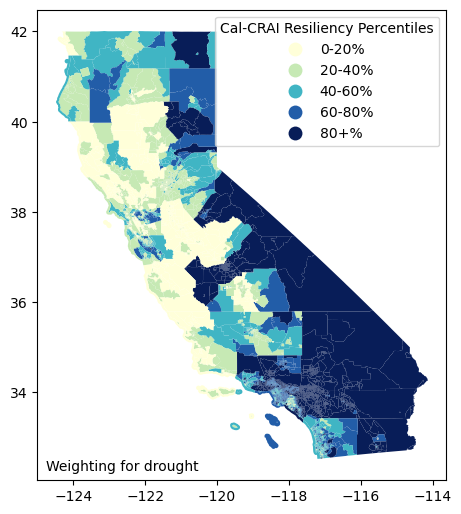

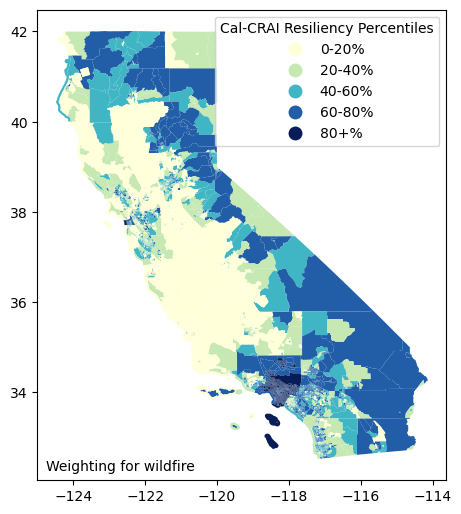

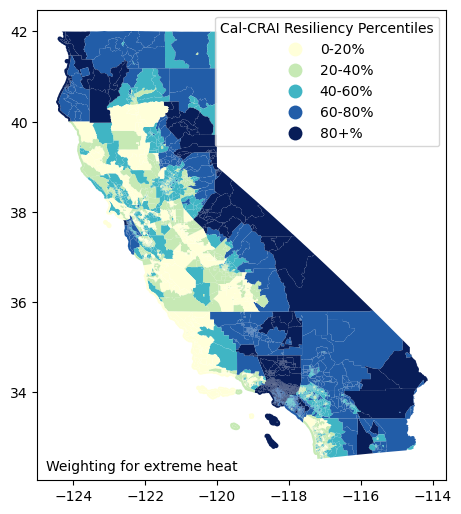

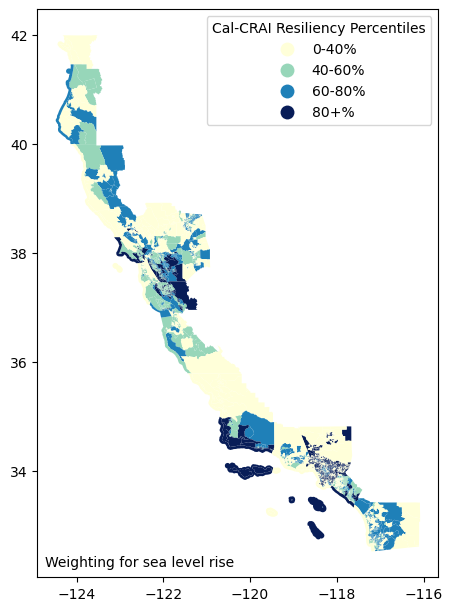

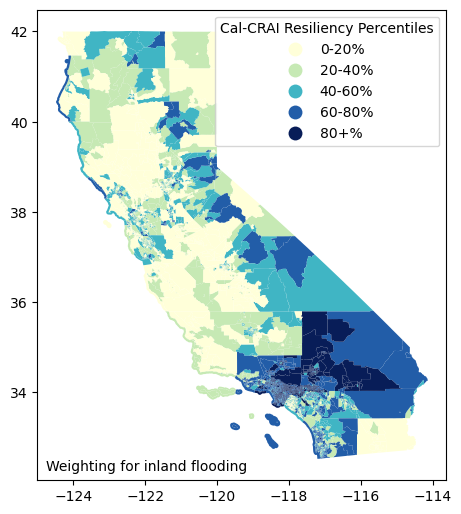

In [34]:
# List of binned columns
binned_columns = [
    'drought_scenario_calcrai_score_quartile',
    'wildfire_scenario_calcrai_score_quartile',
    'extreme_heat_scenario_calcrai_score_quartile',
    'sea_level_rise_scenario_calcrai_score_quartile',
    'inland_flooding_scenario_calcrai_score_quartile',
]

# Loop through each binned column and plot
for column in binned_columns:
    scenario_name = column.split('_scenario')[0]  # Get everything before '_scenario'
    scenario_name = scenario_name.replace('_', ' ')

    index_plot(binned_df_viz, column, save=True, save_name=f'binned {scenario_name}', scenario=scenario_name, vmin=0, vmax=5, plot_type='discrete')

In [35]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files = ['calcrai_index_wildfire_scenario_updated.csv',
        'calcrai_index_heat_scenario_updated.csv',
        'calcrai_index_inland_flooding_scenario_updated.csv',
        'calcrai_index_sea_level_rise_scenario_updated.csv',
        'calcrai_index_drought_scenario_updated.csv']

for file in files:
    upload_csv_aws([file], bucket_name, directory)

calcrai_index_wildfire_scenario_updated.csv uploaded to AWS
calcrai_index_heat_scenario_updated.csv uploaded to AWS
calcrai_index_inland_flooding_scenario_updated.csv uploaded to AWS
calcrai_index_sea_level_rise_scenario_updated.csv uploaded to AWS
calcrai_index_drought_scenario_updated.csv uploaded to AWS
